In [4]:
import pandas as pd
import numpy as np
import chardet

## Data processing

In [5]:
# 文件路径
file_dict_path = 'data_dictionary.csv'
athletes_file_path = 'summerOly_athletes.csv'
hosts_file_path = 'summerOly_hosts.csv'
medals_file_path = 'summerOly_medal_counts.csv'
programs_file_path = 'summerOly_programs.csv'

# 检测文件编码
def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        raw_data = f.read()
        result = chardet.detect(raw_data)
        return result['encoding']

# 直接使用 Pandas 读取 CSV 文件
def read_csv(file_path):
    encoding = detect_encoding(file_path)
    return pd.read_csv(file_path, encoding=encoding)

# 读取数据
data_dict = read_csv(file_dict_path)
df_athletes = read_csv(athletes_file_path)
df_hosts = read_csv(hosts_file_path)
df_medals = read_csv(medals_file_path)
df_programs = read_csv(programs_file_path)

In [7]:
#处理一下俄罗斯奥委会参赛名称
df_medals.loc[df_medals['NOC'] == 'ROC','NOC'] = 'Russia'

In [8]:
# First question: medals prediction model
#我们这里假设只考虑2000年以来参加过奥运会的国家（不考虑苏联等已经解体的国家）
df_athlete_20 = df_athletes[df_athletes['Year'].isin([2000, 2004, 2008, 2012, 2016, 2020, 2024])]
countries = df_athlete_20.loc[:, 'Team'].unique()
countries

array(['China', 'Finland', 'Norway', 'Romania', 'Netherlands', 'France',
       'Morocco', 'Estonia', 'Spain', 'Egypt', 'Italy', 'Azerbaijan',
       'Russia', 'Argentina', 'Cuba', 'Belarus', 'Greece', 'Cameroon',
       'Mexico', 'United States', 'Nicaragua', 'Algeria', 'Bahrain',
       'Iraq', 'Qatar', 'Pakistan', 'Iran', 'Canada', 'Ireland',
       'Australia', 'South Africa', 'Eritrea', 'Sudan', 'Belgium',
       'Palestine', 'Kazakhstan', 'Brunei', 'Kuwait', 'Malaysia',
       'Indonesia', 'Uzbekistan', 'United Arab Emirates', 'Kyrgyzstan',
       'Tajikistan', 'Japan', 'Germany', 'Ethiopia', 'Turkey',
       'Sri Lanka', 'Armenia', "Cote d'Ivoire", 'Kenya', 'Nigeria',
       'Brazil', 'Syria', 'Mali', 'Chile', 'Switzerland', 'Sweden',
       'Guyana', 'Georgia', 'Portugal', 'Angola', 'Colombia', 'Djibouti',
       'Bangladesh', 'Jordan', 'Libya', 'Somalia', 'Saudi Arabia',
       'Venezuela', 'India', 'Great Britain', 'Ghana', 'Uganda',
       'Tunisia', 'Slovenia', 'Honduras', 

In [9]:
#发现有的国家的名称后面带有后缀，对后缀进行处理
# 自定义函数：去掉以 '-1' 或 '-2' 或'-3'或', B'结尾的后缀
def remove_suffix(value):
    if value.endswith('-1') or value.endswith('-2') or value.endswith('-3'):
        return value[:-2]  # 去掉最后两个字符
    if value.endswith(', B'):
        return value[:-3]  # 去掉最后三个字符
    return value

# 应用自定义函数
df_athlete_20.loc[:,'Team'] = df_athlete_20['Team'].apply(remove_suffix)
countries_all = df_athlete_20.loc[:,'Team'].unique()

In [10]:
def remove_suffix(value):
    if value.endswith('\xa0'):
        return value[:-4]  # 去掉最后两个字符
    return value
df_medal_20 = df_medals[df_medals['Year'].isin([2000, 2004, 2008, 2012, 2016, 2020, 2024])]
df_medal_20.loc[:,'NOC'] = df_medal_20['NOC'].apply(remove_suffix)

In [11]:
countries_with_medal = df_medal_20.loc[:,'NOC'].unique()
#筛选出2000年后有派遣运动员参赛但从未获得过奖牌的国家，将其标识为体育发展中国家
countries_3 = []
for country in countries_all:
    if country not in countries_with_medal:
        countries_3.append(country)
countries_3

['Nicaragua',
 'Iraq',
 'Palestine',
 'Brunei',
 "Cote d'Ivoire",
 'Mali',
 'Guyana',
 'Angola',
 'Djibouti',
 'Bangladesh',
 'Libya',
 'Somalia',
 'Honduras',
 'El Salvador',
 'Saint Kitts and Nevis',
 'Liberia',
 'Suriname',
 'Nepal',
 'Palau',
 'American Samoa',
 'Rwanda',
 'Malta',
 'Seychelles',
 'Belize',
 'Comoros',
 'Maldives',
 'Benin',
 'Saint Vincent and the Grenadines',
 'Yemen',
 'Individual Olympic Athletes',
 'Oman',
 'Lebanon',
 'Vanuatu',
 'British Virgin Islands',
 'Central African Republic',
 'Madagascar',
 'Chad',
 'Bosnia and Herzegovina',
 'Guam',
 'Cayman Islands',
 'Timor Leste',
 'Refugee Olympic Athletes',
 'Cape Verde',
 'Laos',
 'Luxembourg',
 'Andorra',
 'Guinea Bissau',
 'Haiti',
 'Federated States of Micronesia',
 'Myanmar',
 'Senegal',
 'Mauritania',
 'Congo (Kinshasa)',
 'Guinea',
 'Antigua and Barbuda',
 'Congo (Brazzaville)',
 'Bolivia',
 'Sierra Leone',
 'Monaco',
 'Equatorial Guinea',
 'United States Virgin Islands',
 'Papua New Guinea',
 'Gambia',


## 预测模型

In [23]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


In [42]:
#pip install XGBoost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.5/124.9 MB 16.5 MB/s eta 0:00:08
   ---------------------------------------- 0.8/124.9 MB 12.5 MB/s eta 0:00:10
   ---------------------------------------- 0.8/124.9 MB 12.5 MB/s eta 0:00:10
   ---------------------------------------- 0.8/124.9 MB 12.5 MB/s eta 0:00:10
   ---------------------------------------- 0.8/124.9 MB 12.5 MB/s eta 0:00:10
   ---------------------------------------- 0.8/124.9 MB 3.4 MB/s eta 0:00:37
   ---------------------------------------- 0.9/124.9 MB 3.0 MB/s eta 0:00:42
   ---------------------------------------- 0.9/124.9 MB 2.6 MB/s eta 0:00:48
   ---------------------------------------- 0.9/124.9 MB 2.6 MB/s eta 0:00:48
   ---------------------------------------- 0.9/124.9 MB 2.0 MB/s eta 0:01:03
   - -------------------------------------- 5.0/124.9 MB 10.0 MB/s eta 0:00:12
   - -------------------------------------- 5.5/124.9 MB 10.4 MB/

In [28]:
#pip install lightgbm

In [12]:
df_athlete_20.head()

,Name,Sex,Team,NOC,Year,City,Sport,Event,Medal
1,A Lamusi,M,China,CHN,2012,London,Judo,Judo Men's Extra-Lightweight,No medal
7,Jyri Aalto,M,Finland,FIN,2000,Sydney,Badminton,Badminton Men's Singles,No medal
9,Minna Aalto,F,Finland,FIN,2000,Sydney,Sailing,Sailing Women's Windsurfer,No medal
31,Timo Aaltonen,M,Finland,FIN,2000,Sydney,Athletics,Athletics Men's Shot Put,No medal
33,Ragnhild Aamodt,F,Norway,NOR,2008,Beijing,Handball,Handball Women's Handball,Gold


In [43]:
# 确保数据按照运动员姓名和年份排序
df_athlete_20 = df_athlete_20.sort_values(by=['Name', 'Year'])
# 1. 运动员参与的次数（基于比赛年份）
df_athlete_20['participation_count'] = df_athlete_20.groupby('Name')['Year'].transform('nunique')
# 2. 计算每个运动员过去获得金银铜奖的最大数量
df_athlete_20['best_performance'] = df_athlete_20.groupby('Name')['Medal'].transform(
   lambda x: x.map({'Gold': 1, 'Silver': 2, 'Bronze': 3}).max())
# 将空值填充为 0，表示从未获得奖牌
df_athlete_20['best_performance'] = df_athlete_20['best_performance'].fillna(0)
#3.添加一个新的列：运动员在上一届奥运会的表现
def get_previous_performance(group):
    # 将奖牌映射为数值，便于比较
    medal_map = {'Gold': 1, 'Silver': 2, 'Bronze': 3}
    performance = group['Medal'].map(medal_map)
    
    # 向前填充“上一届表现”
    group['previous_performance'] = performance.shift(1)
    
    return group

# 按运动员分组并应用函数
df_athlete_20 = df_athlete_20.groupby('Name').apply(get_previous_performance)

# 将空值填充为0（表示之前未参赛或未获奖）
df_athlete_20['previous_performance'] = df_athlete_20['previous_performance'].fillna(0)

# 查看结果
print(df_athlete_20[['Name', 'Year', 'Medal', 'previous_performance']].head(20))

In [44]:
# 添加“是否获奖”列，基于 Medal 列
df_athlete_20['win'] = df_athlete_20['Medal'].apply(lambda x: 1 if x != 'No medal' else 0)

# 特征和目标
X_stage1 = df_athlete_20[["Sex", "Team", "Sport", "Event", "Year","participation_count","previous_performance","best_performance"]]
y_stage1 = df_athlete_20['win']

# 使用 LabelEncoder 转换分类特征
label_encoder = LabelEncoder()
X_stage1['Sex'] = label_encoder.fit_transform(X_stage1['Sex'])
X_stage1['Team'] = label_encoder.fit_transform(X_stage1['Team'])
X_stage1['Sport'] = label_encoder.fit_transform(X_stage1['Sport'])
X_stage1['Event'] = label_encoder.fit_transform(X_stage1['Event'])

# 数据集划分
X_train_stage1, X_test_stage1, y_train_stage1, y_test_stage1 = train_test_split(
    X_stage1, y_stage1, test_size=0.2, random_state=42, stratify=y_stage1
)

# 使用 LightGBM 内置分类特征处理
train_data_stage1 = lgb.Dataset(X_train_stage1, label=y_train_stage1)
test_data_stage1 = lgb.Dataset(X_test_stage1, label=y_test_stage1, reference=train_data_stage1)

# 设置 LightGBM 参数
params_stage1 = {
    "objective": "binary",             # 二分类任务
    "metric": "binary_error",          # 使用二分类错误率作为评估指标
    "boosting_type": "gbdt",           # 使用梯度提升决策树
    "num_leaves": 31,                  # 最大叶子数
    "learning_rate": 0.05,             # 学习率
    "feature_fraction": 0.8            # 特征采样比例
}

# 训练阶段 1 模型
model_stage1 = lgb.train(
    params_stage1,
    train_data_stage1,
    valid_sets=[train_data_stage1, test_data_stage1],
    valid_names=["train", "valid"],
    num_boost_round=1000,
)

# 阶段 1 预测
y_pred_stage1 = model_stage1.predict(X_test_stage1, num_iteration=model_stage1.best_iteration)
y_pred_stage1_binary = (y_pred_stage1 > 0.5).astype(int)

# 评估阶段 1 模型
print("阶段 1 准确率：", accuracy_score(y_test_stage1, y_pred_stage1_binary))
print(classification_report(y_test_stage1, y_pred_stage1_binary))

# Calculate ROC curve for both models
fpr_stage1, tpr_stage1, _ = roc_curve(y_test_stage1, y_pred_stage1)
roc_auc_stage1 = auc(fpr_stage1, tpr_stage1)

C:\Users\zhaochenghao\AppData\Local\Temp\ipykernel_68132\3169567543.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_stage1['Sex'] = label_encoder.fit_transform(X_stage1['Sex'])
C:\Users\zhaochenghao\AppData\Local\Temp\ipykernel_68132\3169567543.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_stage1['Team'] = label_encoder.fit_transform(X_stage1['Team'])
C:\Users\zhaochenghao\AppData\Local\Temp\ipykernel_68132\3169567543.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

[LightGBM] [Info] Number of positive: 11798, number of negative: 66191
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 517
[LightGBM] [Info] Number of data points in the train set: 77989, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.151278 -> initscore=-1.724614
[LightGBM] [Info] Start training from score -1.724614
阶段 1 准确率： 0.9374807672581803
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     16549
           1       0.80      0.77      0.79      2949

    accuracy                           0.94     19498
   macro avg       0.88      0.87      0.88     19498
weighted avg       0.94      0.94      0.94     19498



In [48]:
# 设置优化后的随机森林模型参数
rf_params = {
    'n_estimators': 200,    # 树的数量
    'max_depth': 30,         # 树的最大深度
    'min_samples_split': 2,  # 分割节点的最小样本数
    'min_samples_leaf': 2,   # 叶节点的最小样本数
    'max_features': 'sqrt',  # 每棵树随机选择的特征数
    'random_state': 42      # 设置随机种子
}

# 训练随机森林模型
rf_model_stage1 = RandomForestClassifier(**rf_params)
rf_model_stage1.fit(X_train_stage1, y_train_stage1)

# 获取预测概率
y_pred_stage1_rf = rf_model_stage1.predict_proba(X_test_stage1)[:, 1]
y_pred_stage1_binary_rf = (y_pred_stage1_rf > 0.5).astype(int)

# 评估阶段 1 模型
print("阶段 1 准确率：", accuracy_score(y_test_stage1, y_pred_stage1_binary_rf))
print(classification_report(y_test_stage1, y_pred_stage1_binary_rf))

# 计算ROC曲线和AUC
fpr_rf, tpr_rf, _ = roc_curve(y_test_stage1, y_pred_stage1_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

阶段 1 准确率： 0.9325571853523438
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     16549
           1       0.79      0.76      0.77      2949

    accuracy                           0.93     19498
   macro avg       0.87      0.86      0.87     19498
weighted avg       0.93      0.93      0.93     19498



In [51]:
# 设置XGBoost模型的参数
params = {
    'colsample_bytree': 1.0,
    'learning_rate': 0.1,
    'max_depth': 10,
    'n_estimators': 300,
    'subsample': 0.8,
    'objective': 'binary:logistic',  # 二分类任务
    'eval_metric': 'logloss',        # 评估指标
    'use_label_encoder': False      # 防止警告
}

# 初始化模型
xgb_model_stage1 = xgb.XGBClassifier(**params)

# 训练模型
xgb_model_stage1.fit(X_train_stage1, y_train_stage1)

C:\Users\zhaochenghao\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:52:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [52]:
# 获取预测概率
y_pred_stage1_xgb = xgb_model_stage1.predict_proba(X_test_stage1)[:, 1]
y_pred_stage1_binary_xgb = (y_pred_stage1_xgb > 0.5).astype(int)

# 评估阶段 1 模型
print("阶段 1 准确率：", accuracy_score(y_test_stage1, y_pred_stage1_binary_xgb))
print(classification_report(y_test_stage1, y_pred_stage1_binary_xgb))
# 计算ROC曲线和AUC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_stage1, y_pred_stage1_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

阶段 1 准确率： 0.937326905323623
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     16549
           1       0.80      0.78      0.79      2949

    accuracy                           0.94     19498
   macro avg       0.88      0.87      0.88     19498
weighted avg       0.94      0.94      0.94     19498



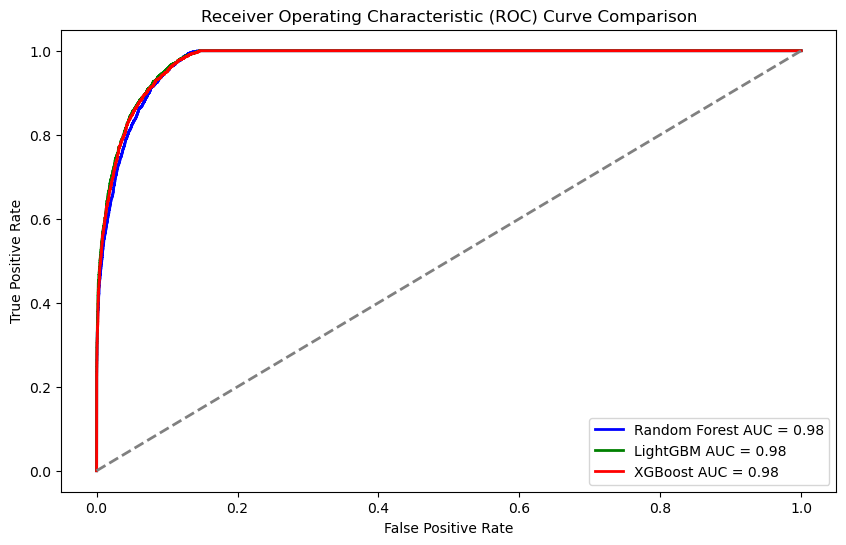

In [53]:
# 绘制ROC曲线对比
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label='Random Forest AUC = %0.2f' % roc_auc_rf)
plt.plot(fpr_stage1, tpr_stage1, color='green', lw=2, label='LightGBM AUC = %0.2f' % roc_auc_stage1)
plt.plot(fpr_xgb, tpr_xgb, color='red', lw=2, label='XGBoost AUC = %0.2f' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # 随机猜测的线

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.legend(loc="lower right")
plt.show()

第二阶段预测结果：
              precision    recall  f1-score   support

      Bronze       0.85      0.91      0.88      1022
        Gold       0.88      0.83      0.85       968
      Silver       0.87      0.85      0.86       960

    accuracy                           0.86      2950
   macro avg       0.87      0.86      0.86      2950
weighted avg       0.86      0.86      0.86      2950



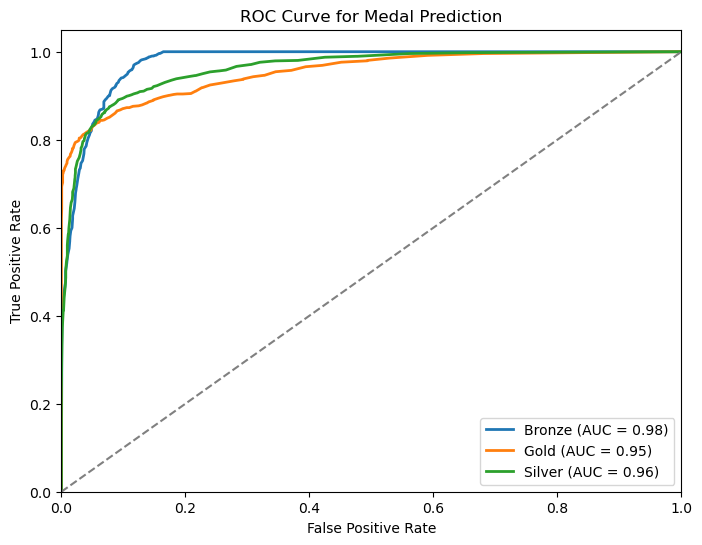

In [54]:
# 第二步：只选择获奖运动员（win == 1）
df_athlete_20_win = df_athlete_20[df_athlete_20['win'] == 1]

# 特征和目标变量
X_stage2 = df_athlete_20_win[["Sex", "Team", "Sport", "Event", "Year","participation_count","previous_performance","best_performance"]]
y_stage2 = df_athlete_20_win['Medal']  # 金银铜奖或无奖（'Gold', 'Silver', 'Bronze', 'No medal'）

# 对每一列进行编码
X_stage2_encoded = X_stage2.copy()
for col in X_stage2_encoded.columns:
    X_stage2_encoded[col] = label_encoder.fit_transform(X_stage2_encoded[col])

# 数据集划分
X_train_stage2, X_test_stage2, y_train_stage2, y_test_stage2 = train_test_split(
    X_stage2_encoded, y_stage2, test_size=0.2, random_state=42, stratify=y_stage2
)

# 训练随机森林模型（可以在此处使用已调优的随机森林模型）
rf_model_stage2 = RandomForestClassifier(random_state=42)

# 训练模型
rf_model_stage2.fit(X_train_stage2, y_train_stage2)

# 获取预测结果
y_pred_stage2 = rf_model_stage2.predict(X_test_stage2)

# 评估模型
from sklearn.metrics import classification_report

print("第二阶段预测结果：")
print(classification_report(y_test_stage2, y_pred_stage2))

# 计算第二阶段的ROC曲线和AUC（可以绘制多个类别的ROC曲线）
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc

lb = LabelBinarizer()
y_test_stage2_bin = lb.fit_transform(y_test_stage2)
y_pred_stage2_proba = rf_model_stage2.predict_proba(X_test_stage2)

# 绘制每个类别的ROC曲线
plt.figure(figsize=(8, 6))
for i in range(len(lb.classes_)):
    fpr, tpr, _ = roc_curve(y_test_stage2_bin[:, i], y_pred_stage2_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{lb.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Medal Prediction')
plt.legend(loc='lower right')
plt.show()

## 状态提取

In [102]:
df_athlete_20.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 97487 entries, ('(jr) Larocca', 243558) to ('zzet Safer', 170838)
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Name                  97487 non-null  object 
 1   Sex                   97487 non-null  object 
 2   Team                  97487 non-null  object 
 3   NOC                   97487 non-null  object 
 4   Year                  97487 non-null  int64  
 5   City                  97487 non-null  object 
 6   Sport                 97487 non-null  object 
 7   Event                 97487 non-null  object 
 8   Medal                 97487 non-null  object 
 9   win                   97487 non-null  int64  
 10  participation_count   97487 non-null  int64  
 11  best_performance      97487 non-null  float64
 12  previous_performance  97487 non-null  float64
dtypes: float64(2), int64(3), object(8)
memory usage: 15.6+ MB


In [ ]:
# 处理奖牌信息，将奖牌转换为数值（例如：无奖牌=0，铜牌=1，银牌=2，金牌=3）
medal_map = {'No medal': 0, 'Bronze': 1, 'Silver': 2, 'Gold': 3}
df_athlete_20['MedalValue'] = df['Medal'].map(medal_map)

# 聚合数据：每个国家每年在每个大项的表现
grouped = df.groupby(['NOC', 'Year', 'Sport'])['MedalValue'].agg(['sum', 'count']).reset_index()

# sum：该年该国该项目的总奖牌数，count：该年该国该项目的参与次数
grouped['MedalRate'] = grouped['sum'] / grouped['count']

# 可以为每个年份设定一个类别，表现好（MedalRate高），普通，疲劳（MedalRate低）
def categorize_performance(row):
    if row['MedalRate'] > 0.5:
        return '优秀'
    elif row['MedalRate'] > 0:
        return '普通'
    else:
        return '疲劳'

grouped['Performance'] = grouped.apply(categorize_performance, axis=1)


## 优势提取

In [87]:
yearly_detailed_medal = pd.read_excel('yearly_detailed_medal.xlsx')

In [88]:
yearly_detailed_medal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20970 entries, 0 to 20969
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      20970 non-null  int64  
 1   NOC             20970 non-null  object 
 2   Year            20970 non-null  int64  
 3   Sport           20970 non-null  object 
 4   Athletes_Count  20970 non-null  int64  
 5   Gold            20970 non-null  int64  
 6   Silver          20970 non-null  int64  
 7   Bronze          20970 non-null  int64  
 8   Total_Medals    20970 non-null  int64  
 9   Events_Count    20970 non-null  int64  
 10  Gold rate       20970 non-null  float64
 11  Silver rate     20970 non-null  float64
 12  Bronze rate     20970 non-null  float64
 13  Medal rate      20970 non-null  float64
dtypes: float64(4), int64(8), object(2)
memory usage: 2.2+ MB


In [89]:
# ---- 1. 过滤掉奖牌总数为 0 的国家和项目 ----
filtered_yearly_detailed_medal = yearly_detailed_medal[yearly_detailed_medal['Total_Medals'] > 0]

# 假设 "近几年" 定义为最近三届奥运会
recent_years = filtered_yearly_detailed_medal['Year'].max() - 12  # 最近三届
filtered_yearly_detailed_medal['Period'] = filtered_yearly_detailed_medal['Year'].apply(lambda x: 'Recent' if x > recent_years else 'Past')

C:\Users\zhaochenghao\AppData\Local\Temp\ipykernel_68132\173523642.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_yearly_detailed_medal['Period'] = filtered_yearly_detailed_medal['Year'].apply(lambda x: 'Recent' if x > recent_years else 'Past')


In [90]:
# 过滤去除 2000 年之前的数据
filtered_yearly_detailed_medal = filtered_yearly_detailed_medal[filtered_yearly_detailed_medal['Year'] >= 2000]

In [91]:
# ---- 2. TOPSIS 分析 ----
# 选择用于分析的特征
features = ['Medal rate', 'Gold rate', 'Silver rate','Bronze rate']

In [97]:
# 确保 final_result 初始化为空
final_result = pd.DataFrame()

# 遍历每个项目（Sport）
for sport, group in filtered_yearly_detailed_medal.groupby('Sport'):
    
    # 分割数据为 Recent 和 Past
    recent_data = group[group['Period'] == 'Recent']
    past_data = group[group['Period'] == 'Past']
    
    # Recent 数据的决策矩阵
    recent_matrix = recent_data[features].values
    recent_normalized = recent_matrix / np.sqrt(np.sum(recent_matrix**2, axis=0))
    weights = np.array([0.4, 0.3, 0.2, 0.1])  # 权重
    recent_weighted = recent_normalized * weights
    ideal_solution_recent = np.max(recent_weighted, axis=0)
    negative_ideal_solution_recent = np.min(recent_weighted, axis=0)
    distance_to_ideal_recent = np.sqrt(np.sum((recent_weighted - ideal_solution_recent) ** 2, axis=1))
    distance_to_negative_recent = np.sqrt(np.sum((recent_weighted - negative_ideal_solution_recent) ** 2, axis=1))
    recent_closeness = distance_to_negative_recent / (distance_to_ideal_recent + distance_to_negative_recent)
    
    # 处理 Past 数据
    if len(past_data) > 0:
        past_matrix = past_data[features].values
        past_normalized = past_matrix / np.sqrt(np.sum(past_matrix**2, axis=0))
        past_weighted = past_normalized * weights
        ideal_solution_past = np.max(past_weighted, axis=0)
        negative_ideal_solution_past = np.min(past_weighted, axis=0)
        distance_to_ideal_past = np.sqrt(np.sum((past_weighted - ideal_solution_past) ** 2, axis=1))
        distance_to_negative_past = np.sqrt(np.sum((past_weighted - negative_ideal_solution_past) ** 2, axis=1))
        past_closeness = distance_to_negative_past / (distance_to_ideal_past + distance_to_negative_past)
    else:
        past_closeness = np.zeros(len(recent_data))  # 如果没有 Past 数据，设置为 0
    
    # Recent 和 Past 的结果 DataFrame
    recent_result = pd.DataFrame({
        'NOC': recent_data['NOC'],
        f'{sport}_Recent_TOPSIS_Score': recent_closeness
    }).drop_duplicates('NOC')

    past_result = pd.DataFrame({
        'NOC': past_data['NOC'] if len(past_data) > 0 else recent_data['NOC'],
        f'{sport}_Past_TOPSIS_Score': past_closeness
    }).drop_duplicates('NOC')
    
    # 合并 Recent 和 Past 的结果，避免列名冲突
    sport_result = pd.merge(recent_result, past_result, on='NOC', how='outer', suffixes=('', '_Past'))

    # 为每个国家计算排名
    sport_result[f'{sport}_Recent_Rank'] = sport_result[f'{sport}_Recent_TOPSIS_Score'].rank(ascending=False, method='dense')
    sport_result[f'{sport}_Past_Rank'] = sport_result[f'{sport}_Past_TOPSIS_Score'].rank(ascending=False, method='dense')

    # 合并到 final_result，避免列名冲突
    final_result = pd.merge(final_result, sport_result, on='NOC', how='outer') if not final_result.empty else sport_result


In [98]:
# ---- 4. 去除 Rank 列，并替换 NaN 为 0 ----
# 去除 Rank 列
final_result = final_result.loc[:, ~final_result.columns.str.contains('Rank')]

# 替换 NaN 为 0
final_result = final_result.fillna(0)

In [99]:
final_result.to_csv('country_sport_topsis_analysis.csv', index=False)